# Introduction

An **Autoencoder** is a type of neural network used for **unsupervised learning**, primarily aimed at learning efficient codings of input data. Its architecture is typically composed of two main parts: Encoder and Decoder.

<center><img src='https://buffml.com/wp-content/uploads/2021/05/autoencoder-feature-img.png'></center>

### 1. Encoder

* **Purpose**: Compresses the input data into a lower-dimensional representation (called the **latent space** or **bottleneck**).
* **Structure**: A series of layers (often fully connected or convolutional) that reduce the input dimensionality.
* **Output**: A latent vector `z` that summarizes the most important features of the input `x`.

### 2. Latent Space (Bottleneck)

* **Purpose**: Acts as a compressed summary of the input data.
* **Size**: Much smaller than the input dimension, enforcing the model to learn meaningful patterns.

### 3. Decoder

* **Purpose**: Reconstructs the input data from the latent vector `z`.
* **Structure**: A mirrored architecture of the encoder that attempts to invert the compression process.
* **Output**: A reconstructed input `x'` that ideally resembles the original input `x`.

### Training an Autoencoder

When training an autoencoder, the objecti is to minimize the **reconstruction loss**, commonly measured using:

* **Mean Squared Error (MSE)** for continuous data,
* **Binary Cross-Entropy** for binary input.

$$
\mathcal{L}(x, x') = \|x - x'\|^2
$$


### **Applications**

* Dimensionality reduction
* Anomaly detection
* Image denoising
* Data compression

# Vanilla Autoencoder

The code below show a complete PyTorch example illustrating how to train an *autoencoder on the MNIST dataset. It includes:

* Data loading
* Encoder and decoder definition
* Training loop
* Visualization of reconstruction results

Requirements:

```bash
pip install torch torchvision matplotlib
```

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 5680601.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 224688.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:02<00:00, 740001.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2044925.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Loss: 0.0242
Epoch [2/5], Loss: 0.0160
Epoch [3/5], Loss: 0.0134
Epoch [4/5], Loss: 0.0121
Epoch [5/5], Loss: 0.0106


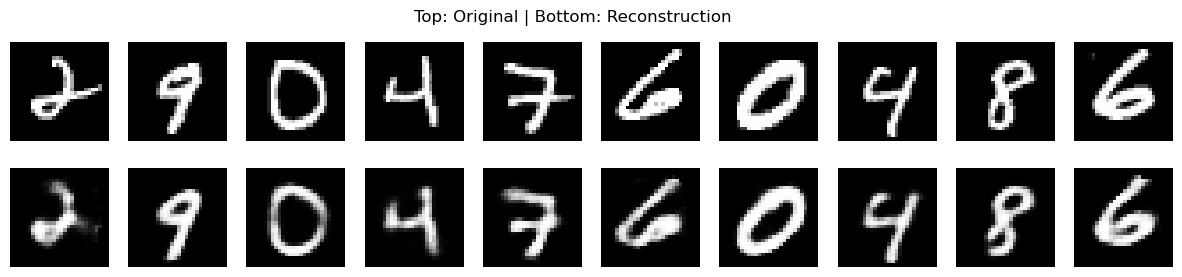

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Visualization
def show_reconstructions(model, n=10):
    model.eval()
    test_imgs, _ = next(iter(train_loader))
    test_imgs = test_imgs[:n].to(device)
    with torch.no_grad():
        recon = model(test_imgs)

    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
    for i in range(n):
        axes[0, i].imshow(test_imgs[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

show_reconstructions(model)

### Visualization of the Latent Space

This code builds a visualization of the **latent space** of the autoencoder using the MNIST dataset. This example projects the 32D latent vectors into 2D using **t-SNE**, colored by digit class.

What This Shows:

* Each point is the latent representation of a digit image.
* Colors represent digit classes (0–9).
* Clusters suggest that the encoder learned class-discriminative features, even though training was **unsupervised**.

/Users/ebezerra/miniconda3/envs/cic1205/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


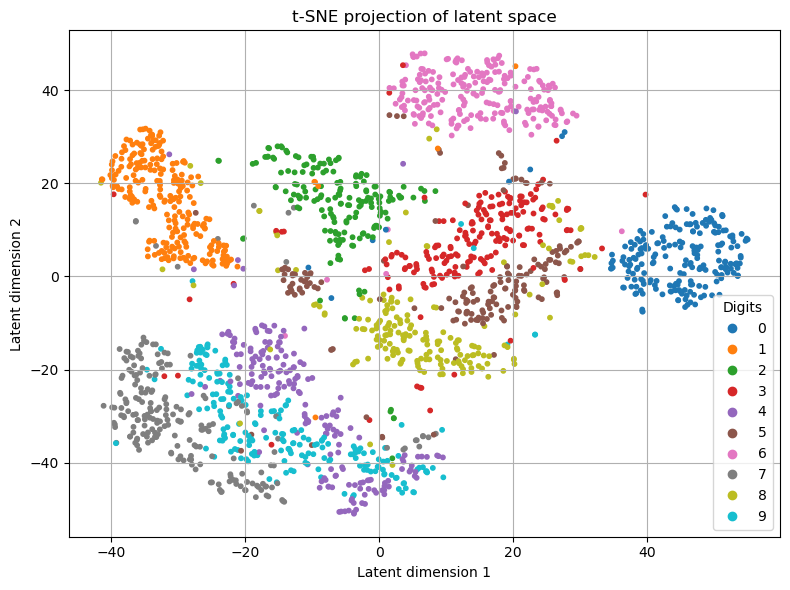

In [18]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, n_samples=2000):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            z = model.encoder(imgs)
            latents.append(z.cpu())
            labels.append(lbls)
            if len(torch.cat(latents)) > n_samples:
                break

    latents = torch.cat(latents)[:n_samples]
    labels = torch.cat(labels)[:n_samples]

    # Reduce to 2D with t-SNE
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digits", loc="best")
    plt.title("t-SNE projection of latent space")
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function on training data
visualize_latent_space(model, train_loader)

# Denoising Autoencoder

**Créditos**

O código apresentado neste notebook e uma adaptação do original produzido por Eugenia Anello quando da escrita do artigo [Denoising Autoencoder in Pytorch on MNIST dataset](https://ai.plainenglish.io/denoising-autoencoder-in-pytorch-on-mnist-dataset-a76b8824e57e).

In [1]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
data_dir = 'dataset'
# With these commands the train and test datasets are automatically
# downloaded and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 5839637.14it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 224459.62it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2063683.17it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2965062.84it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



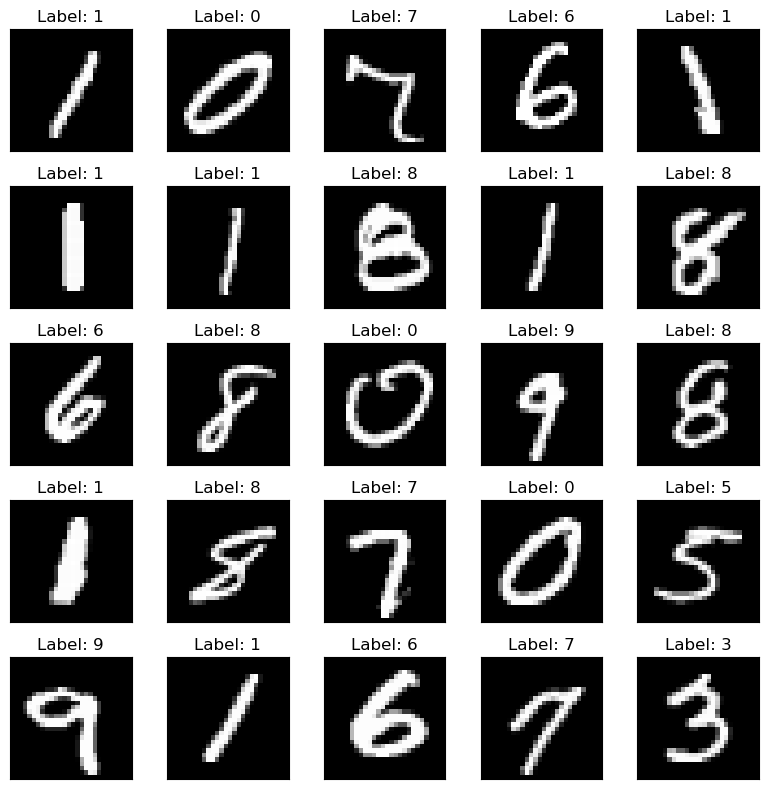

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like 
    # object (basically anything that can be accessed with an index, 
    # like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## Definição do codificador e do decodificador

Nesta seção, as classes do codificador e do decodificador são definidas. Esses dois componentes contêm 3 camadas convolucionais e 2 camadas totalmente conectadas. A diferença é que o decodificador usa camadas de [convolução transposta](https://github.com/vdumoulin/conv_arithmetic).

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## Construção do modelo

Agora, os componentes codificador e decodificador são iniciados. São também definidos a função de custo, o otimizador e o dispositivo para usar GPU.

Repare que a dimensão da camada do código é definida como igual a 4.

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)

In [9]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Treinamento do modelo

A função a seguir aplica um ruído aleatório na imagem de entrada. O resultado dessa função é que será usado como entrada para o treinamento. 

Essa função realiza duas etapas para transformar a imagem de entrada:

- `torch.randn_like` para criar um tensor ruidoso do mesmo tamanho da entrada
- `torch.clip(min=0.,max=1.)` para limitar o intervalo entre 0 e 1

In [10]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs + torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise, 0., 1.)
     return noise

Agora, o código de treinamento de modelo é apresentado.

Há uma função para realizar o treinamento (`train_epoch_den`) e outra para a validação (`test_epoch_den`). Ambas são chamadas em  cada época de treinamento.

Na função `train_epoch_den`, repare que

1. cada imagem do lote é distorcida antes de ser passada para o modelo;
2. a função de custo é avaliada computando o erro (diferença) entre a imagem gerada pelo modelo (`encoded_data`) e a imagem distorcida apresentada na entrada (`image_noisy`).

In [11]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

A função a seguir é definida com o propósito de permitir acompanhar o aprendizado do modelo. Essa função é chamada no fim de cada época de treinamento. Para as cinco primeiras imagens do conjunto de teste, essa função apresenta três visualizações:

- a imagem de entrada original, 
- a imagem após a aplicação do ruído,
- a imagem reconstruída pelo modelo.

In [13]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[i][0].unsqueeze(0)
      image_noisy = add_noise(img, noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

O código a seguir realiza o treinamento. Após 30 épocas, o autoencoder parece reconstruir imagens semelhantes às observadas na entrada. Ainda existem algumas imperfeições, mas há uma clara melhoria em comparação às primeiras épocas, em que o autoencoder ainda não captura as informações mais relevantes para realizar as reconstruções.

EPOCH 1/30
	 partial train loss (single batch): 0.189575
	 partial train loss (single batch): 0.184301
	 partial train loss (single batch): 0.178877
	 partial train loss (single batch): 0.175887
	 partial train loss (single batch): 0.172570
	 partial train loss (single batch): 0.169789
	 partial train loss (single batch): 0.167634
	 partial train loss (single batch): 0.165034
	 partial train loss (single batch): 0.163262
	 partial train loss (single batch): 0.161971
	 partial train loss (single batch): 0.160059
	 partial train loss (single batch): 0.158411
	 partial train loss (single batch): 0.156744
	 partial train loss (single batch): 0.155488
	 partial train loss (single batch): 0.153867
	 partial train loss (single batch): 0.152160
	 partial train loss (single batch): 0.150732
	 partial train loss (single batch): 0.149429
	 partial train loss (single batch): 0.148297
	 partial train loss (single batch): 0.146653
	 partial train loss (single batch): 0.145197
	 partial train loss (s

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


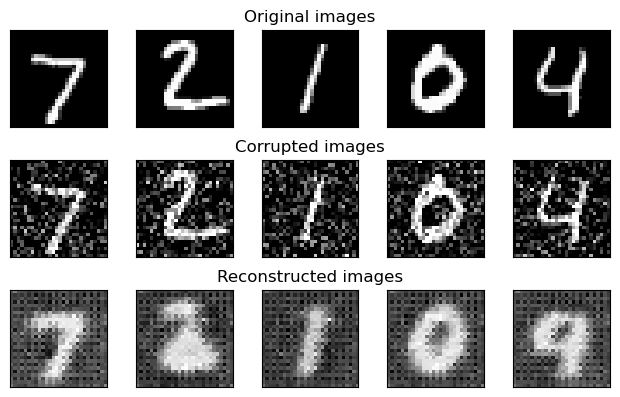

EPOCH 2/30
	 partial train loss (single batch): 0.067397
	 partial train loss (single batch): 0.067356
	 partial train loss (single batch): 0.067136
	 partial train loss (single batch): 0.067220
	 partial train loss (single batch): 0.065795
	 partial train loss (single batch): 0.067147
	 partial train loss (single batch): 0.066527
	 partial train loss (single batch): 0.068525
	 partial train loss (single batch): 0.067042
	 partial train loss (single batch): 0.066409
	 partial train loss (single batch): 0.067146
	 partial train loss (single batch): 0.066053
	 partial train loss (single batch): 0.066684
	 partial train loss (single batch): 0.066443
	 partial train loss (single batch): 0.065332
	 partial train loss (single batch): 0.066446
	 partial train loss (single batch): 0.065697
	 partial train loss (single batch): 0.065317
	 partial train loss (single batch): 0.064980
	 partial train loss (single batch): 0.065377
	 partial train loss (single batch): 0.065854
	 partial train loss (s

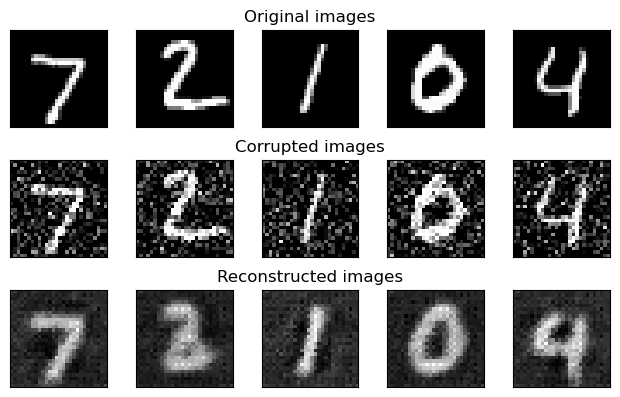

EPOCH 3/30
	 partial train loss (single batch): 0.060514
	 partial train loss (single batch): 0.059062
	 partial train loss (single batch): 0.059320
	 partial train loss (single batch): 0.059802
	 partial train loss (single batch): 0.060701
	 partial train loss (single batch): 0.060053
	 partial train loss (single batch): 0.059173
	 partial train loss (single batch): 0.059700
	 partial train loss (single batch): 0.059580
	 partial train loss (single batch): 0.059186
	 partial train loss (single batch): 0.060156
	 partial train loss (single batch): 0.059690
	 partial train loss (single batch): 0.059829
	 partial train loss (single batch): 0.057953
	 partial train loss (single batch): 0.058245
	 partial train loss (single batch): 0.058615
	 partial train loss (single batch): 0.059427
	 partial train loss (single batch): 0.058818
	 partial train loss (single batch): 0.058823
	 partial train loss (single batch): 0.059522
	 partial train loss (single batch): 0.058070
	 partial train loss (s

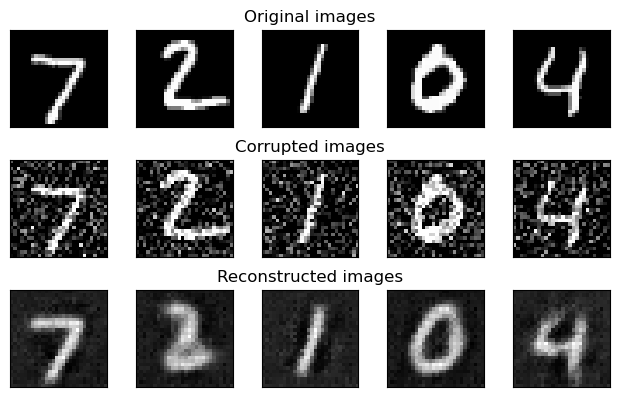

EPOCH 4/30
	 partial train loss (single batch): 0.055138
	 partial train loss (single batch): 0.055341
	 partial train loss (single batch): 0.055499
	 partial train loss (single batch): 0.054201
	 partial train loss (single batch): 0.055211
	 partial train loss (single batch): 0.055657
	 partial train loss (single batch): 0.055304
	 partial train loss (single batch): 0.053986
	 partial train loss (single batch): 0.054938
	 partial train loss (single batch): 0.055059
	 partial train loss (single batch): 0.055849
	 partial train loss (single batch): 0.054757
	 partial train loss (single batch): 0.055346
	 partial train loss (single batch): 0.054630
	 partial train loss (single batch): 0.054621
	 partial train loss (single batch): 0.054439
	 partial train loss (single batch): 0.055595
	 partial train loss (single batch): 0.055136
	 partial train loss (single batch): 0.055727
	 partial train loss (single batch): 0.055793
	 partial train loss (single batch): 0.053567
	 partial train loss (s

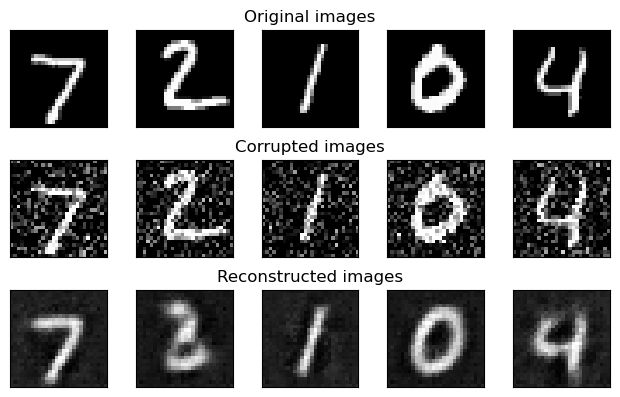

EPOCH 5/30
	 partial train loss (single batch): 0.052851
	 partial train loss (single batch): 0.053440
	 partial train loss (single batch): 0.052695
	 partial train loss (single batch): 0.052803
	 partial train loss (single batch): 0.054326
	 partial train loss (single batch): 0.052848
	 partial train loss (single batch): 0.054101
	 partial train loss (single batch): 0.052766
	 partial train loss (single batch): 0.055008
	 partial train loss (single batch): 0.053039
	 partial train loss (single batch): 0.053261
	 partial train loss (single batch): 0.053085
	 partial train loss (single batch): 0.054242
	 partial train loss (single batch): 0.054081
	 partial train loss (single batch): 0.054068
	 partial train loss (single batch): 0.054410
	 partial train loss (single batch): 0.053197
	 partial train loss (single batch): 0.053111
	 partial train loss (single batch): 0.054261
	 partial train loss (single batch): 0.052573
	 partial train loss (single batch): 0.052646
	 partial train loss (s

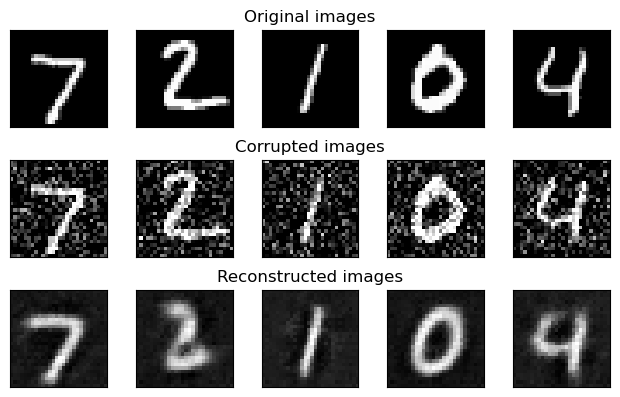

EPOCH 6/30
	 partial train loss (single batch): 0.053459
	 partial train loss (single batch): 0.052398
	 partial train loss (single batch): 0.052056
	 partial train loss (single batch): 0.053037
	 partial train loss (single batch): 0.053273
	 partial train loss (single batch): 0.052861
	 partial train loss (single batch): 0.052254
	 partial train loss (single batch): 0.053153
	 partial train loss (single batch): 0.052778
	 partial train loss (single batch): 0.052079
	 partial train loss (single batch): 0.053012
	 partial train loss (single batch): 0.053232
	 partial train loss (single batch): 0.053717
	 partial train loss (single batch): 0.051766
	 partial train loss (single batch): 0.053724
	 partial train loss (single batch): 0.052156
	 partial train loss (single batch): 0.052915
	 partial train loss (single batch): 0.053036
	 partial train loss (single batch): 0.053011
	 partial train loss (single batch): 0.051881
	 partial train loss (single batch): 0.053125
	 partial train loss (s

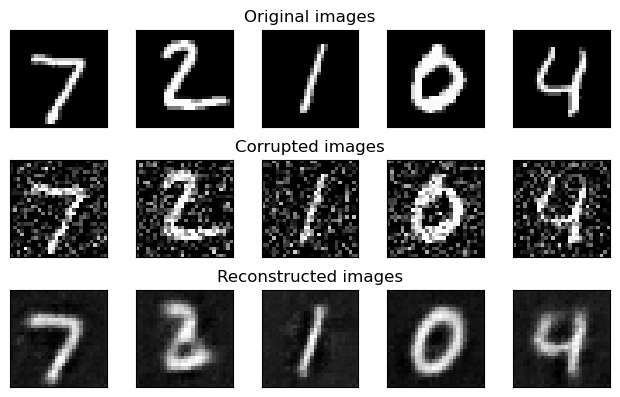

EPOCH 7/30
	 partial train loss (single batch): 0.051968
	 partial train loss (single batch): 0.052190
	 partial train loss (single batch): 0.051903
	 partial train loss (single batch): 0.052539
	 partial train loss (single batch): 0.051822
	 partial train loss (single batch): 0.052838
	 partial train loss (single batch): 0.052885
	 partial train loss (single batch): 0.052373
	 partial train loss (single batch): 0.052647
	 partial train loss (single batch): 0.052386
	 partial train loss (single batch): 0.052137
	 partial train loss (single batch): 0.052076
	 partial train loss (single batch): 0.052987
	 partial train loss (single batch): 0.052186
	 partial train loss (single batch): 0.052243
	 partial train loss (single batch): 0.052425
	 partial train loss (single batch): 0.051667
	 partial train loss (single batch): 0.051868
	 partial train loss (single batch): 0.051866
	 partial train loss (single batch): 0.051709
	 partial train loss (single batch): 0.052707
	 partial train loss (s

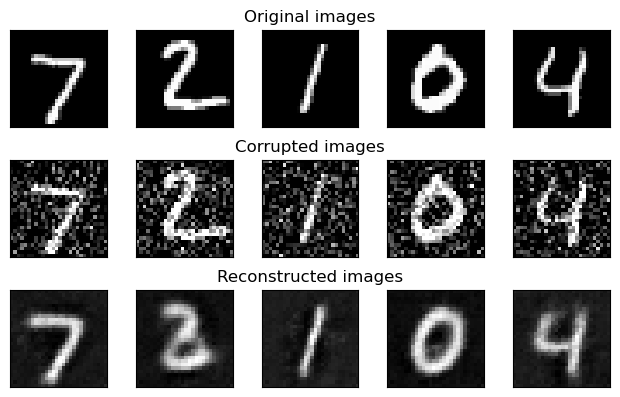

EPOCH 8/30
	 partial train loss (single batch): 0.050750
	 partial train loss (single batch): 0.051870
	 partial train loss (single batch): 0.051903
	 partial train loss (single batch): 0.052576
	 partial train loss (single batch): 0.051858
	 partial train loss (single batch): 0.051531
	 partial train loss (single batch): 0.052382
	 partial train loss (single batch): 0.050874
	 partial train loss (single batch): 0.051068
	 partial train loss (single batch): 0.051995
	 partial train loss (single batch): 0.050664
	 partial train loss (single batch): 0.051852
	 partial train loss (single batch): 0.051444
	 partial train loss (single batch): 0.051257
	 partial train loss (single batch): 0.050116
	 partial train loss (single batch): 0.051444
	 partial train loss (single batch): 0.052695
	 partial train loss (single batch): 0.052471
	 partial train loss (single batch): 0.051572
	 partial train loss (single batch): 0.051875
	 partial train loss (single batch): 0.051927
	 partial train loss (s

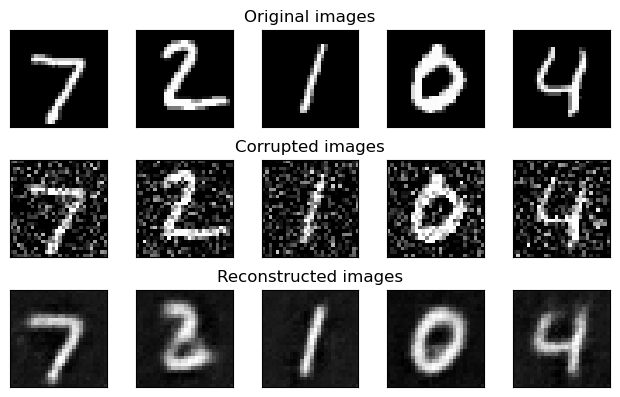

EPOCH 9/30
	 partial train loss (single batch): 0.051899
	 partial train loss (single batch): 0.051083
	 partial train loss (single batch): 0.051523
	 partial train loss (single batch): 0.050773
	 partial train loss (single batch): 0.051486
	 partial train loss (single batch): 0.051370
	 partial train loss (single batch): 0.051464
	 partial train loss (single batch): 0.051966
	 partial train loss (single batch): 0.051834
	 partial train loss (single batch): 0.051456
	 partial train loss (single batch): 0.051566
	 partial train loss (single batch): 0.051795
	 partial train loss (single batch): 0.051360
	 partial train loss (single batch): 0.050534
	 partial train loss (single batch): 0.052012
	 partial train loss (single batch): 0.051325
	 partial train loss (single batch): 0.052315
	 partial train loss (single batch): 0.051571
	 partial train loss (single batch): 0.051653
	 partial train loss (single batch): 0.051404
	 partial train loss (single batch): 0.050385
	 partial train loss (s

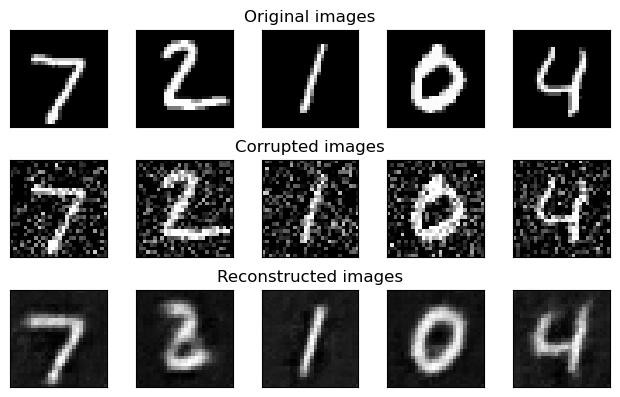

EPOCH 10/30
	 partial train loss (single batch): 0.051869
	 partial train loss (single batch): 0.052143
	 partial train loss (single batch): 0.051733
	 partial train loss (single batch): 0.052288
	 partial train loss (single batch): 0.051012
	 partial train loss (single batch): 0.052132
	 partial train loss (single batch): 0.051833
	 partial train loss (single batch): 0.050657
	 partial train loss (single batch): 0.051572
	 partial train loss (single batch): 0.050511
	 partial train loss (single batch): 0.051694
	 partial train loss (single batch): 0.051479
	 partial train loss (single batch): 0.051187
	 partial train loss (single batch): 0.051305
	 partial train loss (single batch): 0.050875
	 partial train loss (single batch): 0.051355
	 partial train loss (single batch): 0.050549
	 partial train loss (single batch): 0.050676
	 partial train loss (single batch): 0.051588
	 partial train loss (single batch): 0.050389
	 partial train loss (single batch): 0.051386
	 partial train loss (

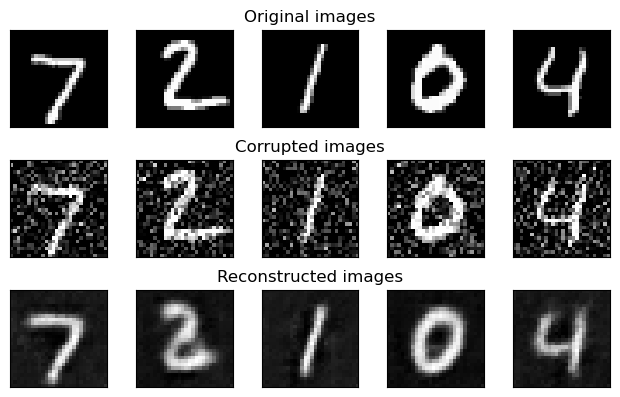

EPOCH 11/30
	 partial train loss (single batch): 0.051640
	 partial train loss (single batch): 0.052079
	 partial train loss (single batch): 0.050559
	 partial train loss (single batch): 0.051111
	 partial train loss (single batch): 0.052494
	 partial train loss (single batch): 0.051029
	 partial train loss (single batch): 0.051864
	 partial train loss (single batch): 0.052529
	 partial train loss (single batch): 0.050474
	 partial train loss (single batch): 0.051344
	 partial train loss (single batch): 0.051548
	 partial train loss (single batch): 0.050135
	 partial train loss (single batch): 0.050073
	 partial train loss (single batch): 0.050188
	 partial train loss (single batch): 0.050374
	 partial train loss (single batch): 0.050991
	 partial train loss (single batch): 0.050888
	 partial train loss (single batch): 0.051823
	 partial train loss (single batch): 0.051686
	 partial train loss (single batch): 0.051640
	 partial train loss (single batch): 0.050522
	 partial train loss (

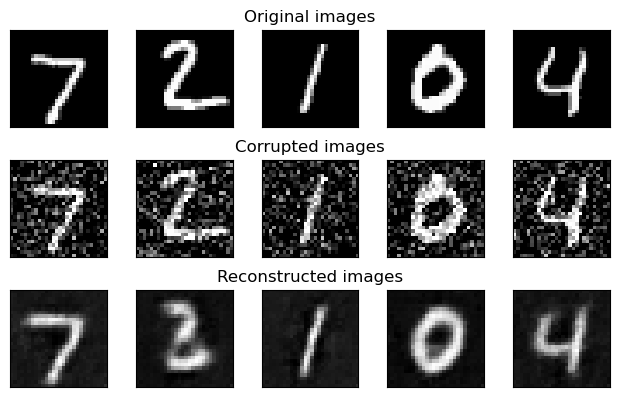

EPOCH 12/30
	 partial train loss (single batch): 0.051210
	 partial train loss (single batch): 0.050410
	 partial train loss (single batch): 0.050371
	 partial train loss (single batch): 0.051196
	 partial train loss (single batch): 0.050700
	 partial train loss (single batch): 0.051731
	 partial train loss (single batch): 0.050887
	 partial train loss (single batch): 0.051255
	 partial train loss (single batch): 0.051549
	 partial train loss (single batch): 0.051418
	 partial train loss (single batch): 0.051207
	 partial train loss (single batch): 0.051685
	 partial train loss (single batch): 0.049064
	 partial train loss (single batch): 0.051894
	 partial train loss (single batch): 0.050596
	 partial train loss (single batch): 0.050564
	 partial train loss (single batch): 0.050461
	 partial train loss (single batch): 0.051425
	 partial train loss (single batch): 0.050590
	 partial train loss (single batch): 0.051844
	 partial train loss (single batch): 0.050170
	 partial train loss (

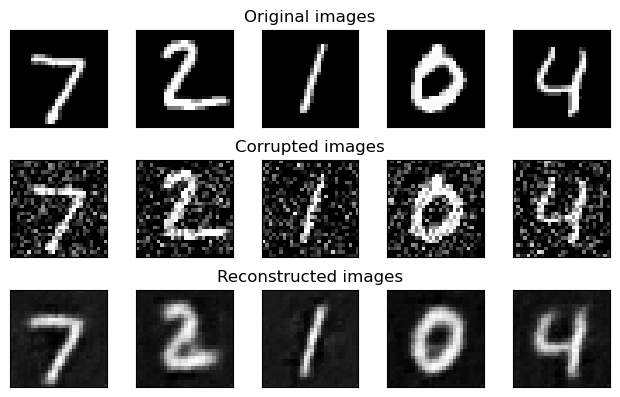

EPOCH 13/30
	 partial train loss (single batch): 0.050329
	 partial train loss (single batch): 0.051073
	 partial train loss (single batch): 0.050444
	 partial train loss (single batch): 0.050872
	 partial train loss (single batch): 0.050828
	 partial train loss (single batch): 0.051189
	 partial train loss (single batch): 0.050779
	 partial train loss (single batch): 0.050894
	 partial train loss (single batch): 0.049757
	 partial train loss (single batch): 0.050256
	 partial train loss (single batch): 0.051442
	 partial train loss (single batch): 0.050237
	 partial train loss (single batch): 0.050633
	 partial train loss (single batch): 0.050519
	 partial train loss (single batch): 0.051062
	 partial train loss (single batch): 0.050960
	 partial train loss (single batch): 0.049840
	 partial train loss (single batch): 0.050815
	 partial train loss (single batch): 0.050331
	 partial train loss (single batch): 0.050415
	 partial train loss (single batch): 0.051007
	 partial train loss (

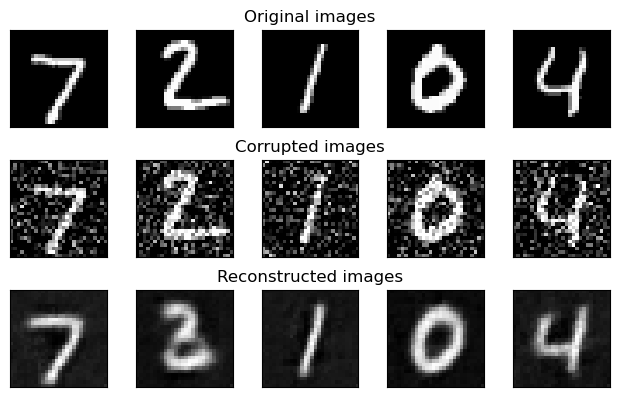

EPOCH 14/30
	 partial train loss (single batch): 0.050380
	 partial train loss (single batch): 0.050121
	 partial train loss (single batch): 0.049969
	 partial train loss (single batch): 0.050256
	 partial train loss (single batch): 0.050838
	 partial train loss (single batch): 0.050006
	 partial train loss (single batch): 0.050575
	 partial train loss (single batch): 0.050272
	 partial train loss (single batch): 0.051395
	 partial train loss (single batch): 0.050116
	 partial train loss (single batch): 0.050376
	 partial train loss (single batch): 0.051521
	 partial train loss (single batch): 0.050925
	 partial train loss (single batch): 0.050998
	 partial train loss (single batch): 0.051052
	 partial train loss (single batch): 0.051082
	 partial train loss (single batch): 0.051330
	 partial train loss (single batch): 0.051741
	 partial train loss (single batch): 0.050492
	 partial train loss (single batch): 0.050226
	 partial train loss (single batch): 0.050085
	 partial train loss (

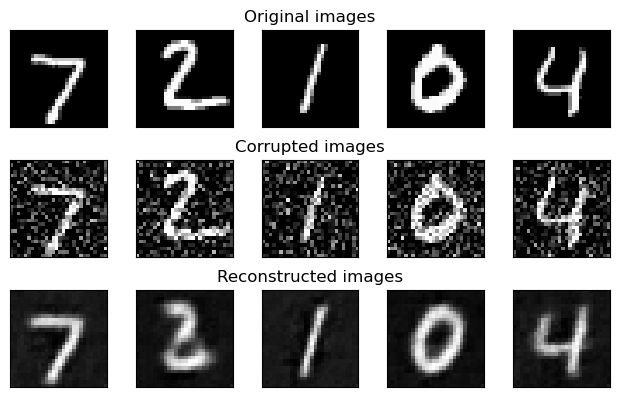

EPOCH 15/30
	 partial train loss (single batch): 0.050383
	 partial train loss (single batch): 0.050331
	 partial train loss (single batch): 0.050857
	 partial train loss (single batch): 0.050389
	 partial train loss (single batch): 0.051065
	 partial train loss (single batch): 0.050972
	 partial train loss (single batch): 0.050447
	 partial train loss (single batch): 0.051267
	 partial train loss (single batch): 0.050877
	 partial train loss (single batch): 0.049693
	 partial train loss (single batch): 0.050537
	 partial train loss (single batch): 0.049818
	 partial train loss (single batch): 0.049937
	 partial train loss (single batch): 0.050763
	 partial train loss (single batch): 0.050583
	 partial train loss (single batch): 0.050954
	 partial train loss (single batch): 0.050407
	 partial train loss (single batch): 0.049894
	 partial train loss (single batch): 0.050661
	 partial train loss (single batch): 0.050346
	 partial train loss (single batch): 0.050850
	 partial train loss (

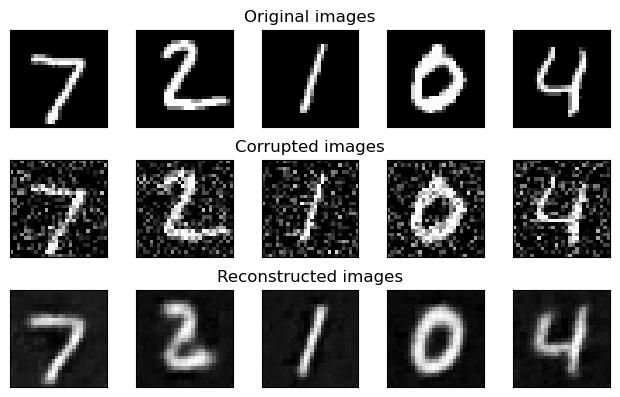

EPOCH 16/30
	 partial train loss (single batch): 0.050189
	 partial train loss (single batch): 0.050823
	 partial train loss (single batch): 0.049926
	 partial train loss (single batch): 0.050712
	 partial train loss (single batch): 0.049398
	 partial train loss (single batch): 0.050810
	 partial train loss (single batch): 0.049271
	 partial train loss (single batch): 0.050872
	 partial train loss (single batch): 0.049676
	 partial train loss (single batch): 0.050418
	 partial train loss (single batch): 0.050214
	 partial train loss (single batch): 0.049615
	 partial train loss (single batch): 0.051122
	 partial train loss (single batch): 0.051405
	 partial train loss (single batch): 0.049786
	 partial train loss (single batch): 0.050686
	 partial train loss (single batch): 0.049789
	 partial train loss (single batch): 0.050934
	 partial train loss (single batch): 0.051232
	 partial train loss (single batch): 0.050368
	 partial train loss (single batch): 0.050364
	 partial train loss (

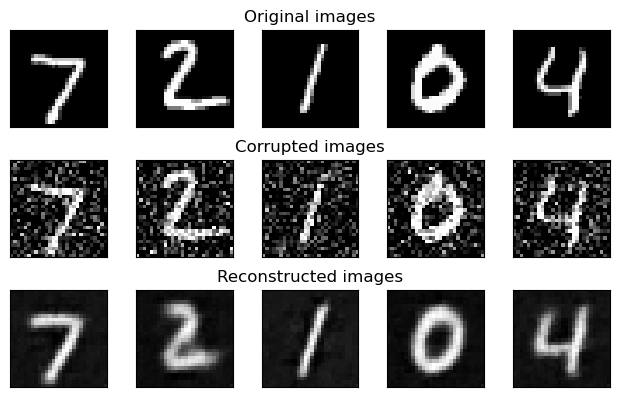

EPOCH 17/30
	 partial train loss (single batch): 0.050643
	 partial train loss (single batch): 0.050371
	 partial train loss (single batch): 0.050589
	 partial train loss (single batch): 0.051396
	 partial train loss (single batch): 0.049754
	 partial train loss (single batch): 0.050236
	 partial train loss (single batch): 0.050525
	 partial train loss (single batch): 0.050524
	 partial train loss (single batch): 0.050240
	 partial train loss (single batch): 0.050413
	 partial train loss (single batch): 0.050434
	 partial train loss (single batch): 0.051078
	 partial train loss (single batch): 0.049193
	 partial train loss (single batch): 0.049111
	 partial train loss (single batch): 0.050520
	 partial train loss (single batch): 0.050683
	 partial train loss (single batch): 0.049230
	 partial train loss (single batch): 0.051141
	 partial train loss (single batch): 0.050748
	 partial train loss (single batch): 0.050571
	 partial train loss (single batch): 0.050668
	 partial train loss (

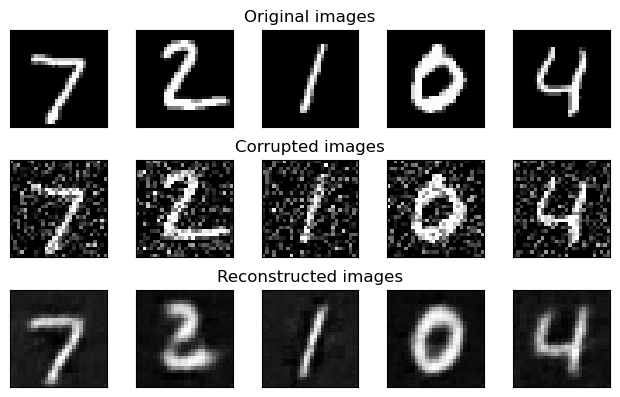

EPOCH 18/30
	 partial train loss (single batch): 0.051105
	 partial train loss (single batch): 0.050392
	 partial train loss (single batch): 0.050233
	 partial train loss (single batch): 0.049548
	 partial train loss (single batch): 0.050341
	 partial train loss (single batch): 0.050420
	 partial train loss (single batch): 0.050136
	 partial train loss (single batch): 0.050191
	 partial train loss (single batch): 0.049511
	 partial train loss (single batch): 0.050001
	 partial train loss (single batch): 0.050152
	 partial train loss (single batch): 0.051558
	 partial train loss (single batch): 0.051084
	 partial train loss (single batch): 0.049462
	 partial train loss (single batch): 0.049794
	 partial train loss (single batch): 0.050908
	 partial train loss (single batch): 0.050930
	 partial train loss (single batch): 0.050818
	 partial train loss (single batch): 0.050964
	 partial train loss (single batch): 0.051080
	 partial train loss (single batch): 0.049469
	 partial train loss (

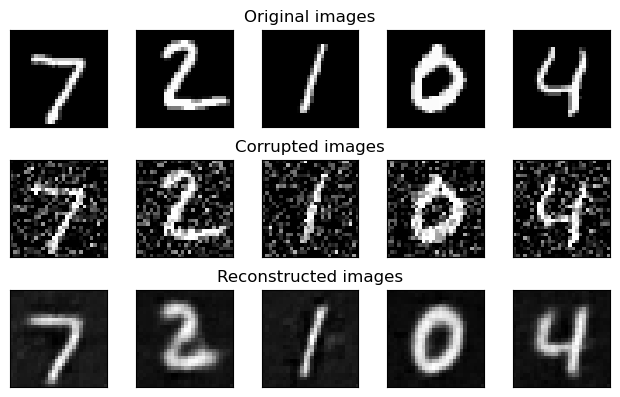

EPOCH 19/30
	 partial train loss (single batch): 0.050783
	 partial train loss (single batch): 0.050577
	 partial train loss (single batch): 0.049405
	 partial train loss (single batch): 0.050515
	 partial train loss (single batch): 0.050271
	 partial train loss (single batch): 0.049132
	 partial train loss (single batch): 0.050455
	 partial train loss (single batch): 0.050632
	 partial train loss (single batch): 0.050240
	 partial train loss (single batch): 0.048922
	 partial train loss (single batch): 0.050878
	 partial train loss (single batch): 0.049692
	 partial train loss (single batch): 0.049758
	 partial train loss (single batch): 0.050642
	 partial train loss (single batch): 0.049571
	 partial train loss (single batch): 0.049962
	 partial train loss (single batch): 0.050118
	 partial train loss (single batch): 0.050003
	 partial train loss (single batch): 0.050930
	 partial train loss (single batch): 0.049512
	 partial train loss (single batch): 0.050549
	 partial train loss (

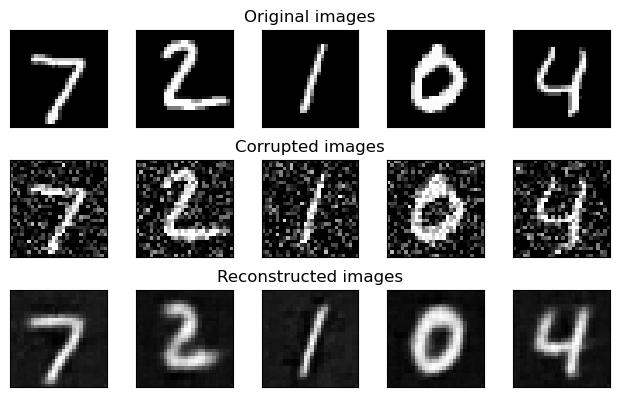

EPOCH 20/30
	 partial train loss (single batch): 0.049997
	 partial train loss (single batch): 0.049679
	 partial train loss (single batch): 0.050326
	 partial train loss (single batch): 0.050109
	 partial train loss (single batch): 0.049712
	 partial train loss (single batch): 0.050570
	 partial train loss (single batch): 0.050469
	 partial train loss (single batch): 0.049709
	 partial train loss (single batch): 0.049658
	 partial train loss (single batch): 0.049788
	 partial train loss (single batch): 0.049838
	 partial train loss (single batch): 0.050419
	 partial train loss (single batch): 0.049649
	 partial train loss (single batch): 0.049900
	 partial train loss (single batch): 0.049115
	 partial train loss (single batch): 0.049612
	 partial train loss (single batch): 0.050060
	 partial train loss (single batch): 0.050075
	 partial train loss (single batch): 0.049895
	 partial train loss (single batch): 0.049950
	 partial train loss (single batch): 0.049532
	 partial train loss (

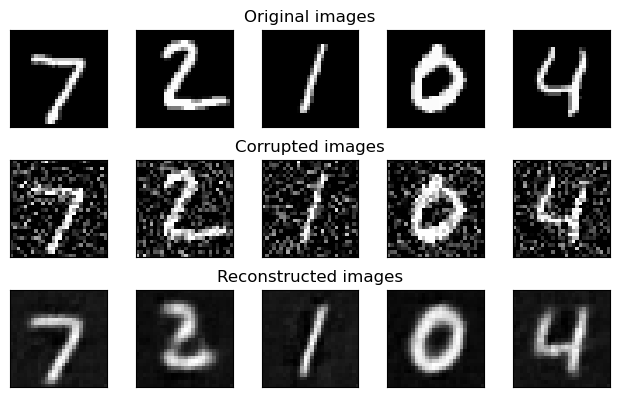

EPOCH 21/30
	 partial train loss (single batch): 0.050449
	 partial train loss (single batch): 0.051043
	 partial train loss (single batch): 0.050263
	 partial train loss (single batch): 0.050373
	 partial train loss (single batch): 0.049964
	 partial train loss (single batch): 0.050538
	 partial train loss (single batch): 0.050509
	 partial train loss (single batch): 0.050037
	 partial train loss (single batch): 0.049806
	 partial train loss (single batch): 0.050083
	 partial train loss (single batch): 0.050141
	 partial train loss (single batch): 0.049334
	 partial train loss (single batch): 0.050092
	 partial train loss (single batch): 0.050063
	 partial train loss (single batch): 0.050300
	 partial train loss (single batch): 0.050119
	 partial train loss (single batch): 0.049372
	 partial train loss (single batch): 0.050624
	 partial train loss (single batch): 0.050111
	 partial train loss (single batch): 0.050104
	 partial train loss (single batch): 0.050210
	 partial train loss (

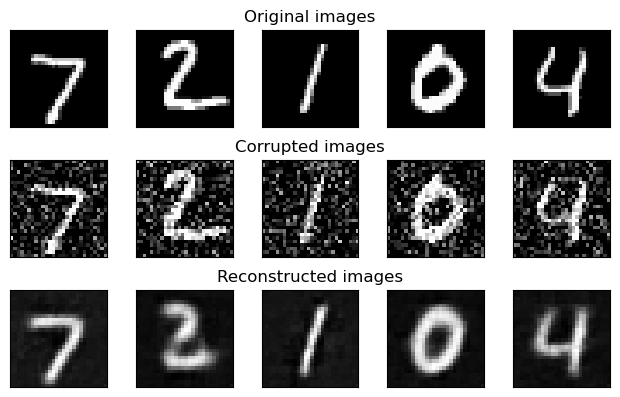

EPOCH 22/30
	 partial train loss (single batch): 0.051250
	 partial train loss (single batch): 0.050451
	 partial train loss (single batch): 0.049741
	 partial train loss (single batch): 0.050182
	 partial train loss (single batch): 0.050979
	 partial train loss (single batch): 0.050438
	 partial train loss (single batch): 0.049322
	 partial train loss (single batch): 0.048769
	 partial train loss (single batch): 0.049825
	 partial train loss (single batch): 0.050125
	 partial train loss (single batch): 0.050192
	 partial train loss (single batch): 0.050208
	 partial train loss (single batch): 0.049582
	 partial train loss (single batch): 0.050040
	 partial train loss (single batch): 0.049897
	 partial train loss (single batch): 0.049786
	 partial train loss (single batch): 0.050788
	 partial train loss (single batch): 0.049723
	 partial train loss (single batch): 0.049927
	 partial train loss (single batch): 0.049818
	 partial train loss (single batch): 0.049239
	 partial train loss (

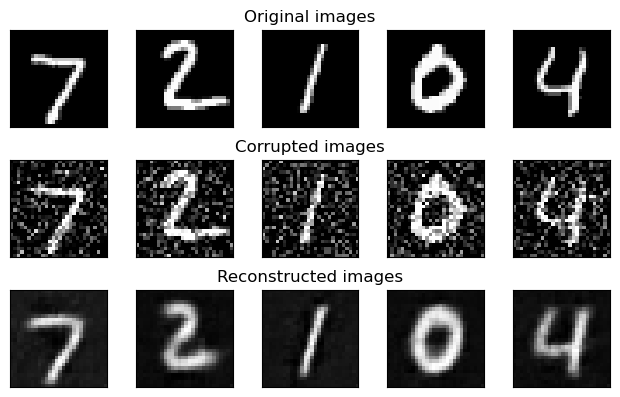

EPOCH 23/30
	 partial train loss (single batch): 0.050331
	 partial train loss (single batch): 0.050600
	 partial train loss (single batch): 0.049586
	 partial train loss (single batch): 0.049200
	 partial train loss (single batch): 0.050846
	 partial train loss (single batch): 0.049851
	 partial train loss (single batch): 0.049127
	 partial train loss (single batch): 0.048679
	 partial train loss (single batch): 0.050777
	 partial train loss (single batch): 0.049466
	 partial train loss (single batch): 0.049851
	 partial train loss (single batch): 0.050558
	 partial train loss (single batch): 0.049930
	 partial train loss (single batch): 0.050906
	 partial train loss (single batch): 0.050058
	 partial train loss (single batch): 0.050092
	 partial train loss (single batch): 0.049469
	 partial train loss (single batch): 0.050519
	 partial train loss (single batch): 0.049202
	 partial train loss (single batch): 0.049728
	 partial train loss (single batch): 0.049860
	 partial train loss (

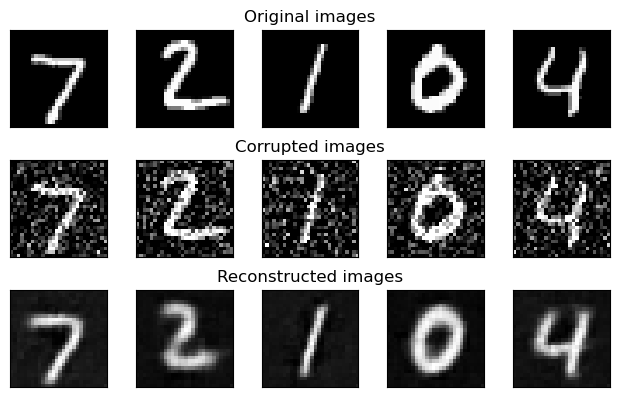

EPOCH 24/30
	 partial train loss (single batch): 0.049859
	 partial train loss (single batch): 0.050244
	 partial train loss (single batch): 0.049577
	 partial train loss (single batch): 0.048932
	 partial train loss (single batch): 0.050197
	 partial train loss (single batch): 0.050152
	 partial train loss (single batch): 0.049654
	 partial train loss (single batch): 0.050692
	 partial train loss (single batch): 0.050560
	 partial train loss (single batch): 0.049960
	 partial train loss (single batch): 0.050330
	 partial train loss (single batch): 0.050567
	 partial train loss (single batch): 0.049605
	 partial train loss (single batch): 0.049009
	 partial train loss (single batch): 0.049534
	 partial train loss (single batch): 0.049774
	 partial train loss (single batch): 0.051590
	 partial train loss (single batch): 0.049591
	 partial train loss (single batch): 0.050258
	 partial train loss (single batch): 0.049907
	 partial train loss (single batch): 0.049145
	 partial train loss (

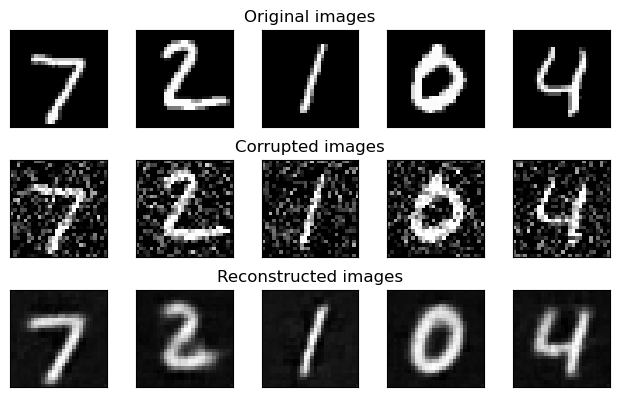

EPOCH 25/30
	 partial train loss (single batch): 0.049459
	 partial train loss (single batch): 0.049364
	 partial train loss (single batch): 0.050987
	 partial train loss (single batch): 0.049436
	 partial train loss (single batch): 0.049879
	 partial train loss (single batch): 0.049186
	 partial train loss (single batch): 0.049803
	 partial train loss (single batch): 0.048891
	 partial train loss (single batch): 0.049829
	 partial train loss (single batch): 0.050135
	 partial train loss (single batch): 0.051539
	 partial train loss (single batch): 0.050214
	 partial train loss (single batch): 0.049774
	 partial train loss (single batch): 0.049663
	 partial train loss (single batch): 0.050084
	 partial train loss (single batch): 0.049647
	 partial train loss (single batch): 0.049361
	 partial train loss (single batch): 0.049311
	 partial train loss (single batch): 0.050610
	 partial train loss (single batch): 0.049630
	 partial train loss (single batch): 0.050617
	 partial train loss (

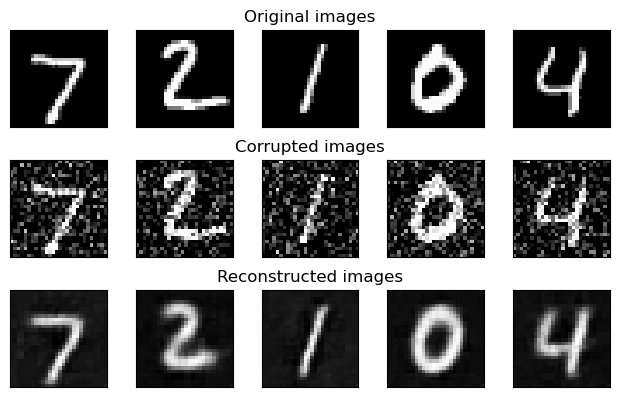

EPOCH 26/30
	 partial train loss (single batch): 0.049405
	 partial train loss (single batch): 0.049842
	 partial train loss (single batch): 0.049211
	 partial train loss (single batch): 0.049183
	 partial train loss (single batch): 0.049807
	 partial train loss (single batch): 0.049146
	 partial train loss (single batch): 0.049499
	 partial train loss (single batch): 0.048484
	 partial train loss (single batch): 0.050164
	 partial train loss (single batch): 0.049612
	 partial train loss (single batch): 0.049170
	 partial train loss (single batch): 0.048869
	 partial train loss (single batch): 0.050087
	 partial train loss (single batch): 0.049315
	 partial train loss (single batch): 0.049173
	 partial train loss (single batch): 0.049799
	 partial train loss (single batch): 0.049835
	 partial train loss (single batch): 0.050398
	 partial train loss (single batch): 0.048733
	 partial train loss (single batch): 0.049751
	 partial train loss (single batch): 0.049776
	 partial train loss (

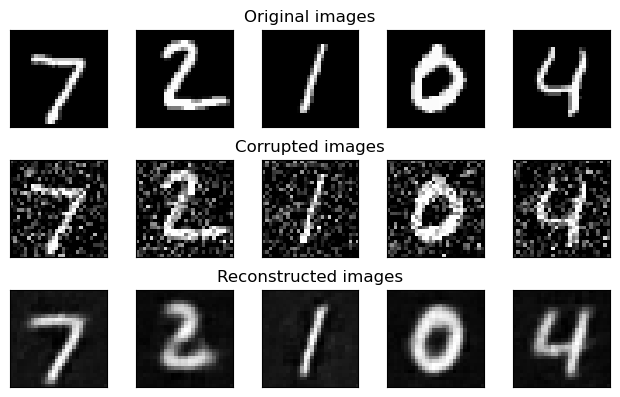

EPOCH 27/30
	 partial train loss (single batch): 0.049872
	 partial train loss (single batch): 0.050124
	 partial train loss (single batch): 0.048985
	 partial train loss (single batch): 0.050006
	 partial train loss (single batch): 0.049263
	 partial train loss (single batch): 0.048782
	 partial train loss (single batch): 0.049721
	 partial train loss (single batch): 0.050102
	 partial train loss (single batch): 0.049409
	 partial train loss (single batch): 0.049953
	 partial train loss (single batch): 0.048932
	 partial train loss (single batch): 0.048597
	 partial train loss (single batch): 0.049646
	 partial train loss (single batch): 0.049511
	 partial train loss (single batch): 0.050547
	 partial train loss (single batch): 0.049650
	 partial train loss (single batch): 0.049189
	 partial train loss (single batch): 0.048830
	 partial train loss (single batch): 0.050315
	 partial train loss (single batch): 0.049594
	 partial train loss (single batch): 0.049065
	 partial train loss (

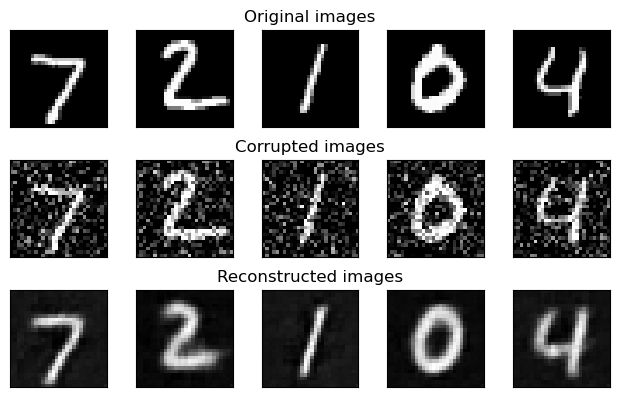

EPOCH 28/30
	 partial train loss (single batch): 0.049394
	 partial train loss (single batch): 0.050153
	 partial train loss (single batch): 0.049694
	 partial train loss (single batch): 0.049242
	 partial train loss (single batch): 0.050095
	 partial train loss (single batch): 0.049852
	 partial train loss (single batch): 0.050330
	 partial train loss (single batch): 0.051019
	 partial train loss (single batch): 0.049739
	 partial train loss (single batch): 0.049560
	 partial train loss (single batch): 0.049958
	 partial train loss (single batch): 0.049582
	 partial train loss (single batch): 0.050025
	 partial train loss (single batch): 0.049756
	 partial train loss (single batch): 0.049769
	 partial train loss (single batch): 0.049395
	 partial train loss (single batch): 0.049374
	 partial train loss (single batch): 0.048828
	 partial train loss (single batch): 0.049706
	 partial train loss (single batch): 0.049374
	 partial train loss (single batch): 0.050214
	 partial train loss (

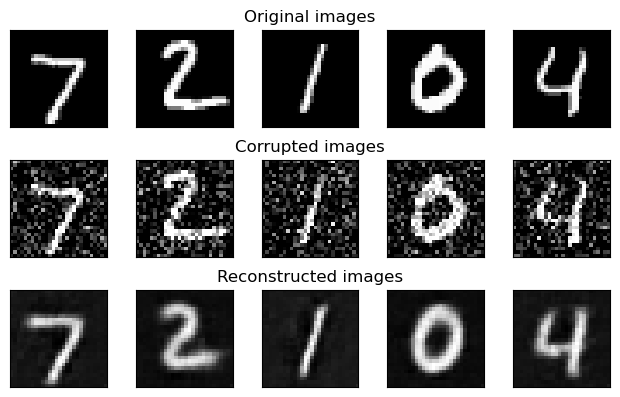

EPOCH 29/30
	 partial train loss (single batch): 0.049598
	 partial train loss (single batch): 0.049372
	 partial train loss (single batch): 0.049425
	 partial train loss (single batch): 0.049679
	 partial train loss (single batch): 0.050007
	 partial train loss (single batch): 0.049207
	 partial train loss (single batch): 0.049224
	 partial train loss (single batch): 0.049310
	 partial train loss (single batch): 0.049515
	 partial train loss (single batch): 0.050727
	 partial train loss (single batch): 0.048345
	 partial train loss (single batch): 0.048348
	 partial train loss (single batch): 0.050375
	 partial train loss (single batch): 0.050129
	 partial train loss (single batch): 0.049711
	 partial train loss (single batch): 0.050369
	 partial train loss (single batch): 0.049255
	 partial train loss (single batch): 0.049254
	 partial train loss (single batch): 0.049174
	 partial train loss (single batch): 0.049197
	 partial train loss (single batch): 0.048948
	 partial train loss (

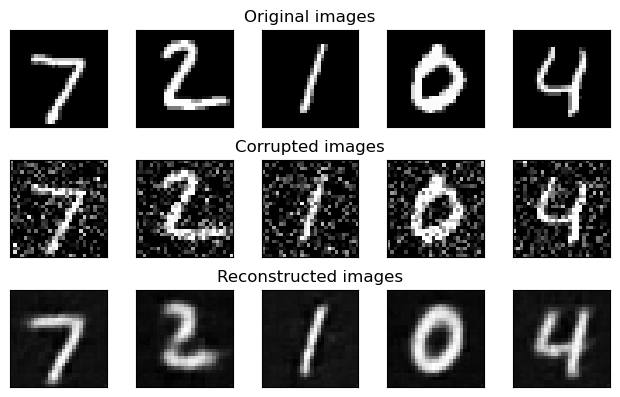

EPOCH 30/30
	 partial train loss (single batch): 0.049297
	 partial train loss (single batch): 0.050754
	 partial train loss (single batch): 0.049464
	 partial train loss (single batch): 0.050455
	 partial train loss (single batch): 0.048918
	 partial train loss (single batch): 0.050138
	 partial train loss (single batch): 0.049038
	 partial train loss (single batch): 0.048976
	 partial train loss (single batch): 0.050264
	 partial train loss (single batch): 0.048518
	 partial train loss (single batch): 0.049689
	 partial train loss (single batch): 0.049920
	 partial train loss (single batch): 0.049628
	 partial train loss (single batch): 0.049245
	 partial train loss (single batch): 0.050717
	 partial train loss (single batch): 0.050503
	 partial train loss (single batch): 0.050430
	 partial train loss (single batch): 0.049409
	 partial train loss (single batch): 0.050473
	 partial train loss (single batch): 0.049519
	 partial train loss (single batch): 0.049813
	 partial train loss (

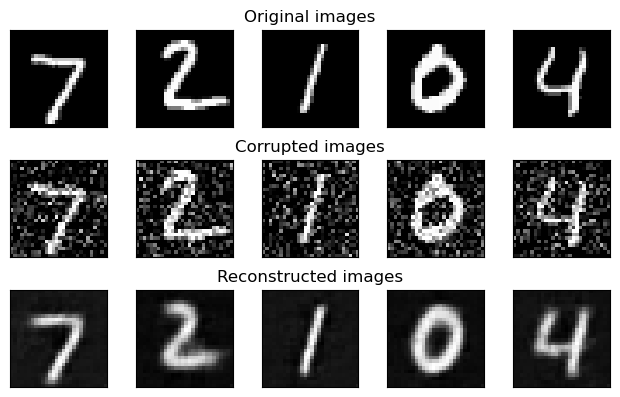

In [14]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,
        noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


In [15]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

0.038527458906173706

## Avaliação do modelo

### Geração de novas imagens

Uma forma de avaliar o desempenho do autoencoder é por meio da geração de novas imagens a partir de códigos latentes produzidos de forma aleatória.

Algumas imagens resultantes apresentam dígitos que parecem bem nítidos, como os correspondentes ao 4 e ao 9. Outras imagens não têm sentido, pois o espaço latente permanece irregular.

In [16]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated taking in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

### Visualização do espaço latente

Podemos também obter uma visualização (de um subespaço) do espaço latente aprendido pelo modelo. 

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:12<00:00, 796.61it/s]


In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.240910,2.034981,0.372571,-1.720647,7
1,0.200876,0.526066,1.202599,0.652493,2
2,0.196210,2.005375,-0.489884,0.456262,1
3,-0.210009,-0.962749,-0.215851,0.036340,0
4,0.348812,-0.106136,-1.052809,-0.922085,4
...,...,...,...,...,...
9995,-0.962719,0.624966,1.339632,0.411555,2
9996,0.430324,0.028879,1.263772,0.390703,3
9997,-0.168513,0.801560,-1.622523,-0.535899,4
9998,-0.332767,0.062890,-0.579878,0.690341,5


In [ ]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

Para fins de comparação, o código a seguir realiza uma redução de dimensionalidade como um método bastante eficiente conhecido como t-SNE.

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()